## Forecasting - OLS, LASSO, PCA, Trees, Forests, Networks

In [79]:
# Import necessary libraries
import os
import time
import random

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization
from tensorflow.keras.models import Model


from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

# Setting a seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

In [80]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Ensure GPU is visible
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print('Using GPU')
    except RuntimeError as e:
        print(e)
else:
    print('No GPU')

No GPU


## Preprocessing

#### Step 1: Download the Data

In [81]:
# Retrieve the data
def load_data(local_file_path: Path, fred_path: str):
    """
    Function to load data either from a local file or from FRED if the file doesn't exist locally.

    Args:
    local_file_path (Path): Local path to the dataset.
    fred_path (str): URL to fetch the dataset from FRED.

    Returns:
    DataFrame: Loaded dataset.
    """
    if local_file_path.is_file():
        print("Local file found")
        df = pd.read_csv(local_file_path)
    else:
        print("Be patient: loading from FRED (2 minutes)")
        df = pd.read_csv(fred_path)
        print("Done")

    # Drop unnecessary row
    df.drop(0, inplace=True)

    # Set index to date and format it as datetime
    df = df.set_index("sasdate", drop=True)
    df.index = pd.to_datetime(df.index, format='%m/%d/%Y')

    return df


#### Step 2: Define the target variable

In [82]:
# Define the target variable (S&P 500 Returns)
def preprocess_data(df):
    """
    Preprocess the data by creating the target variable (S&P 500 log returns) and removing NaNs.

    Args:
    df (DataFrame): Data containing S&P 500 returns.

    Returns:
    DataFrame: Processed data with target variable.
    """
    df['Target'] = (np.log(df['S&P 500']/df['S&P 500'].shift(1)))
    df['Target'] = df['Target'].shift(periods=-1)
    df.drop('S&P 500', axis=1, inplace=True)
    df = df.apply(lambda x: x.fillna(x.rolling(window=6, min_periods=1).mean()))
    df.dropna(inplace=True)

    return df

#### Step 3: Scale and Split the Data

In [83]:
# Creating training and test sets, standardizing the data
def split_and_scale_data(df):
    """
    Splits the data into training and test sets and scales them.

    Args:
    df (DataFrame): Preprocessed data.

    Returns:
    Tuple: Scaled training and test datasets.
    """
    train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)

    scaler = StandardScaler()
    train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), index=train_data.index, columns=train_data.columns)
    test_data_scaled = pd.DataFrame(scaler.transform(test_data), index=test_data.index, columns=test_data.columns)

    return train_data_scaled, test_data_scaled

## Defining the Models

#### Defining the PCA model

In [84]:
# Estimate the PCA model
def apply_pca(train_data_scaled, test_data_scaled):
    """
    Apply PCA to the training and test datasets.

    Args:
    train_data_scaled (DataFrame): Scaled training data.
    test_data_scaled (DataFrame): Scaled test data.

    Returns:
    Tuple: Transformed training and test data after PCA.
    """
    pca = PCA(n_components=4, whiten=True, svd_solver='full')
    pca.fit(train_data_scaled.drop("Target", axis=1))

    train_pca = pd.DataFrame(pca.transform(train_data_scaled.drop("Target", axis=1)), index=train_data_scaled.index)
    test_pca = pd.DataFrame(pca.transform(test_data_scaled.drop("Target", axis=1)), index=test_data_scaled.index)

    return train_pca, test_pca

#### The NN architecture


Beginning with the architecture from last week

In [85]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)


# Define the neural network model
def build_neural_network(input_dim, l2_reg, dropout_rate):
    """
    Function to build a neural network model for regression tasks.

    Args:
    input_dim (int): Number of features (input dimension).

    Returns:
    model: Compiled neural network model.
    """
    inputs = Input(shape=(input_dim,))
    x = MCDropout(dropout_rate)(inputs)
    x = Dense(8, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = MCDropout(dropout_rate)(x)
    x = Dense(4, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = MCDropout(dropout_rate)(x)
    x = Dense(2, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = MCDropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')

    print(model.summary())

    return model

## Estimating the Models

#### Callbacks

In [86]:
# Create the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',             # Monitor validation loss
    patience=5,                     # Stop after 5 epochs with no improvement
    restore_best_weights=True       # Restore model weights from the best epoch
)

In [87]:
# Estimating the Forecasting Models
def train_models(train_data_scaled, train_pca, input_dim):
    """
    Train multiple forecasting models (OLS, LASSO, Decision Tree, Random Forest, and Neural Network).

    Args:
    train_data_scaled (DataFrame): Scaled training data.
    train_pca (DataFrame): Training data after applying PCA.
    input_dim (int): Input dimension for the neural network model.

    Returns:
    Dict: Trained models.
    """
    models = {
        'ols': LinearRegression(fit_intercept=True).fit(train_data_scaled.drop("Target", axis=1),
                                                        train_data_scaled["Target"]),
        'ols_pca': LinearRegression(fit_intercept=True).fit(train_pca, train_data_scaled["Target"]),
        'lasso': Lasso(alpha=0.005, fit_intercept=True).fit(train_data_scaled.drop("Target", axis=1),
                                                            train_data_scaled['Target']),
        'd_tree': DecisionTreeRegressor(max_depth=1000).fit(train_data_scaled.drop("Target", axis=1),
                                                            train_data_scaled["Target"]),
        'r_forest': RandomForestRegressor(max_depth=1000, random_state=0, n_estimators=2).fit(
            train_data_scaled.drop("Target", axis=1), train_data_scaled["Target"])
    }

    # Neural Network training
    ann_model = build_neural_network(input_dim, 0.0001, 0.15)

    start = time.time()
    # Train the neural network model
    history = ann_model.fit(
        train_data_scaled.drop("Target", axis=1),
        train_data_scaled["Target"],
        epochs=200,
        batch_size=16,
        validation_split=0.4,
        verbose=1,
        shuffle=False,
        callbacks=[early_stopping]  # lr_scheduler
    )
    end = time.time()

    print(end - start)

    # Add the trained ANN model to the models dictionary
    models['ann'] = ann_model

    return models, history

## Generating Forecasts

In [88]:
# Forecasts from the trained models
def generate_forecasts(models, test_data_scaled, test_pca):
    """
    Generate forecasts from the trained models.

    Args:
    models (Dict): Dictionary of trained models.
    test_data_scaled (DataFrame): Scaled test data.
    test_pca (DataFrame): Test data after applying PCA.

    Returns:
    Dict: Forecasts from each model.
    """
    predictions = []

    # Run MC dropout for stochastic forward passes
    for i in range(1000):
        pred = models['ann'](test_data_scaled.drop("Target", axis=1), training=True)
        predictions.append(pred)

    # Stack predictions and compute the mean along the 0th axis
    predictions = np.stack(predictions, axis=0)
    mean_prediction = np.mean(predictions, axis=0)
    st_dev_prediction = np.std(predictions, axis=0)

    forecasts = {
        'ols': models['ols'].predict(test_data_scaled.drop("Target", axis=1)),
        'ols_pca': models['ols_pca'].predict(test_pca),
        'lasso': models['lasso'].predict(test_data_scaled.drop("Target", axis=1)),
        'd_tree': models['d_tree'].predict(test_data_scaled.drop("Target", axis=1)),
        'r_forest': models['r_forest'].predict(test_data_scaled.drop("Target", axis=1)),
        'ann': mean_prediction,
        'ann_st_dev': st_dev_prediction,
    }

    return forecasts

## Evaluating the Forecasts

In [89]:
# Evaluation of the models
def evaluate_models(forecasts, test_data_scaled):
    """
    Evaluate the models' performance using Mean Squared Error and Mean Absolute Error.

    Args:
    forecasts (Dict): Forecasts generated by each model.
    test_data_scaled (DataFrame): Scaled test data.

    Returns:
    None
    """

    target = test_data_scaled["Target"].values
    # Iterate through all but the last item
    for model_name, forecast in list(forecasts.items())[:-1]:
        mse = mean_squared_error(target, forecast)
        mae = mean_absolute_error(target, forecast)
        print(f"{model_name}: MSE = {mse}, MAE = {mae}")


In [90]:
# Visualize the forecasts
def plot_forecasts(forecasts, test_data_scaled):
    """
    Plot the forecasts alongside the observed values.

    Args:
    forecasts (Dict): Forecasts generated by each model.
    test_data_scaled (DataFrame): Scaled test data.

    Returns:
    None
    """

    plt.figure()
    plt.plot(test_data_scaled.index, test_data_scaled["Target"], linewidth=1, color='black', label='Observed')
    for model_name, forecast in list(forecasts.items())[-2:]:
        plt.plot(test_data_scaled.index, forecast, '--', linewidth=1, label=model_name)
    plt.title('Return Forecasts')
    plt.xlabel('Date')
    plt.ylabel('Estimated Returns')
    plt.legend()
    plt.show()

## Execute the Code



Be patient: loading from FRED (2 minutes)
Done
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 125)]             0         
                                                                 
 mc_dropout_28 (MCDropout)   (None, 125)               0         
                                                                 
 dense_28 (Dense)            (None, 8)                 1008      
                                                                 
 mc_dropout_29 (MCDropout)   (None, 8)                 0         
                                                                 
 dense_29 (Dense)            (None, 4)                 36        
                                                                 
 mc_dropout_30 (MCDropout)   (None, 4)                 0         
                                                                 
 dense_30 (D

/Users/justincase/PycharmProjects/FINANCE 781/.venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.459e+00, tolerance: 3.120e-02
  model = cd_fast.enet_coordinate_descent(


 mc_dropout_31 (MCDropout)   (None, 2)                 0         
                                                                 
 dense_31 (Dense)            (None, 1)                 3         
                                                                 
Total params: 1057 (4.13 KB)
Trainable params: 1057 (4.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/200
12/12 [==============================] - 1s 14ms/step - loss: 0.9262 - val_loss: 1.4635
Epoch 2/200
12/12 [==============================] - 0s 3ms/step - loss: 0.8513 - val_loss: 1.5124
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 0.8297 - val_loss: 1.4982
Epoch 4/200
12/12 [==============================] - 0s 3ms/step - loss: 0.8237 - val_loss: 1.5738
Epoch 5/200
12/12 [==============================] - 0s 3ms/step - loss: 0.8309 - val_loss: 1.6006
Epoch 6/200
12/12 [==============================] - 0s 3ms/step - loss

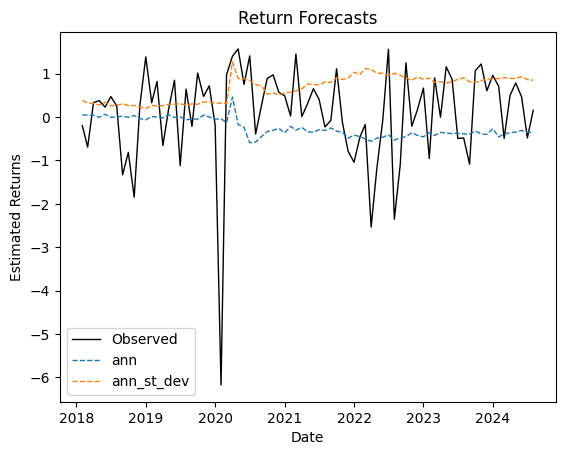

In [91]:
# Define paths for the dataset
fred_path = "https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv"
local_file_path = Path("data/current.csv")

# Load the data
df = load_data(local_file_path, fred_path)

# Preprocess the data
df = preprocess_data(df)

# Split and scale the data
train_data_scaled, test_data_scaled = split_and_scale_data(df)

# Apply PCA
train_pca, test_pca = apply_pca(train_data_scaled, test_data_scaled)

# Train models
input_dim = len(train_data_scaled.columns) - 1  # Exclude the target column for input dimensions
models, history = train_models(train_data_scaled, train_pca, input_dim)

# Generate forecasts
forecasts = generate_forecasts(models, test_data_scaled, test_pca)

# Evaluate models
evaluate_models(forecasts, test_data_scaled)

# Plot forecasts
plot_forecasts(forecasts, test_data_scaled)

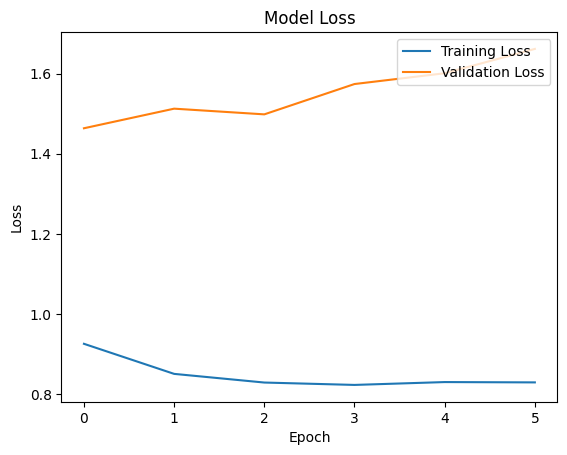

In [92]:
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()